<div class='bar_title'></div>

*Decision Support Systems*

# Headline

student1, student2, student3, student,4 <br>

Winter Semester 19/20

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></div>

In [1]:
!pip install pulp
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
df = pd.read_csv("https://github.com/wi3jmu/DSS1920/raw/master/Data/pecanstreet2.csv", sep=';', decimal=",")
df = df.fillna(method='ffill')
df['consum'] = df['grid (93) (kw)'] + df['solar (93) (kw)']
df['solar'] = np.where(df['solar (93) (kw)'] < 0, 0, df['solar (93) (kw)'])
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('DateTime').groupby(pd.Grouper(freq='D')).sum()
df = df[['solar','consum']]

In [3]:
df.head()

,solar,consum
DateTime,,
2018-01-01,33.351,79.007
2018-01-02,12.853,78.090
2018-01-03,73.625,67.852
2018-01-04,63.614,49.206
2018-01-05,68.268,63.973


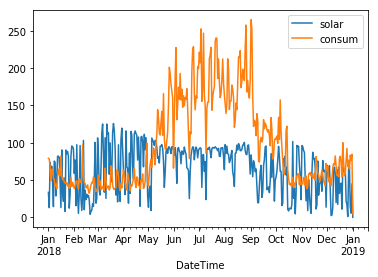

In [4]:
df.plot()
plt.show()

In [5]:
df=df.reset_index()
days = df.index.tolist()
consum = df.consum.to_dict()
solar_available = df.solar.to_dict()

## Implementation

In [6]:
# Create model
m1 = LpProblem("Solar System", sense=pulp.LpMinimize)

In [7]:
# Parameters
batterie_cost = 84/15
recycling_cost = 150
buying_price = 0.3

In [8]:
# Variables
solar_elec = LpVariable.dicts("solar_elec", days, lowBound=0, cat='Continuous')
buying_elec = LpVariable.dicts("buying_elec", days, lowBound=0, cat='Continuous')
battery_elec = LpVariable.dicts("battery_elec", days, lowBound=0, cat='Continuous')

battery_status = LpVariable.dicts("battery_status", days, lowBound=0, cat='Continuous')
battery_charge = LpVariable.dicts("battery_charge", days, lowBound=0, cat='Continuous')

batterie_kap = LpVariable("batterie_kap", lowBound=0, cat='Continuous')

In [9]:
# Objective
m1 += lpSum([150+ batterie_cost * batterie_kap] + [buying_price * buying_elec[t] for t in days])

In [10]:
# Constraints
for t in days:
    m1 += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum[t]
    
    m1 += solar_elec[t] + battery_charge[t] <= solar_available[t]
    
    if (t==0):  
        m1 += 0 - battery_elec[t] + battery_charge[t] == battery_status[t]
    else:
        m1 += battery_status[t-1] - battery_elec[t] + battery_charge[t] == battery_status[t]
        
    m1 += battery_status[t] <= batterie_kap

In [11]:
# Solve problem
m1.solve()
print (LpStatus[m1.status])
obj1 = value(m1.objective)
print (obj1)

Optimal
4575.1941000000015


27.411


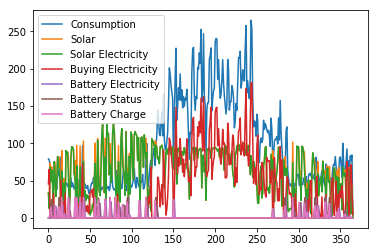

,Consumption,Solar,Solar Electricity,Buying Electricity,Battery Electricity,Battery Status,Battery Charge
0,79.007,33.351,33.351,45.656,0.0,0.000,0.000
1,78.090,12.853,12.853,65.237,0.0,0.000,0.000
2,67.852,73.625,67.852,0.000,0.0,5.773,5.773
3,49.206,63.614,49.206,0.000,0.0,20.181,14.408
4,63.973,68.268,63.973,0.000,0.0,24.476,4.295


In [12]:
kap1 = batterie_kap.varValue
print(batterie_kap.varValue)

out1 = pd.DataFrame([[consum[t], solar_available[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue,
                     battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption', 'Solar', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity',
                              'Battery Status', 'Battery Charge'])

out1.plot()
plt.show()
out1.head()

In [13]:
# Copy Model
# New objective, same constraints
m2 = m1.copy()
m2 += batterie_cost*0.8 * batterie_kap + [buying_price * buying_elec[t] for t in days]

C:\Users\Toni Greif\Anaconda3\lib\site-packages\pulp\pulp.py:1349: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [14]:
# Solve problem
m2.solve()
print (LpStatus[m2.status])
obj2 = value(m2.objective)
print (obj2)

Optimal
4391.8540200000025


34.344


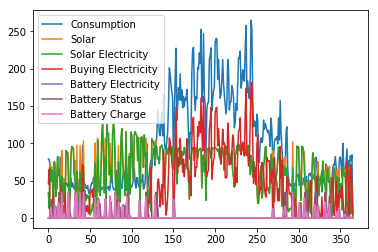

,Consumption,Solar,Solar Electricity,Buying Electricity,Battery Electricity,Battery Status,Battery Charge
0,79.007,33.351,33.351,45.656,0.0,0.000,0.000
1,78.090,12.853,12.853,65.237,0.0,0.000,0.000
2,67.852,73.625,67.852,0.000,0.0,5.773,5.773
3,49.206,63.614,49.206,0.000,0.0,20.181,14.408
4,63.973,68.268,63.973,0.000,0.0,24.476,4.295


In [15]:
kap2 = batterie_kap.varValue
print(batterie_kap.varValue)

out2 = pd.DataFrame([[consum[t], solar_available[t],  solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue,
                     battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption', 'Solar', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity',
                              'Battery Status', 'Battery Charge'])

out2.plot()
plt.show()
out2.head()

In [16]:
# Create NEW model
m3 = LpProblem("Solar System", sense=pulp.LpMinimize)

# New Parameter
selling_price = 0.15

# New additional variables
selling_elec = LpVariable.dicts("selling_elec", days, lowBound=0, cat='Continuous')

In [17]:
# Objective
m3 += lpSum([150 + batterie_cost * batterie_kap] + [buying_price * buying_elec[t] -
                                                    selling_price * selling_elec[t] for t in days])

In [18]:
# Constraints
for t in days:
    m3 += solar_elec[t] + buying_elec[t] + battery_elec[t] >= consum[t]
    
    m3 += solar_elec[t] + battery_charge[t] + selling_elec[t] <= solar_available[t]
    
    if (t==0):   
        m3 += lpSum([0 - battery_elec[t] + battery_charge[t]]) == battery_status[t]
    else:
        m3 += lpSum([battery_status[t-1] - battery_elec[t] + battery_charge[t]]) == battery_status[t]
        
    m3 += lpSum([battery_status[t]]) <= batterie_kap

In [19]:
# Solve problem
m3.solve()
print (LpStatus[m3.status])
obj3 = value(m3.objective)
print (obj3)

Optimal
4089.1697499999987


1.985


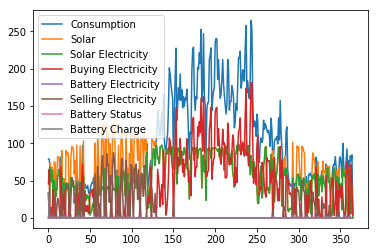

,Consumption,Solar,Solar Electricity,Buying Electricity,Battery Electricity,Selling Electricity,Battery Status,Battery Charge
0,79.007,33.351,0.000,45.656,33.351,0.000,0.000,33.351
1,78.090,12.853,12.853,65.237,0.000,0.000,0.000,0.000
2,67.852,73.625,67.852,0.000,0.000,5.773,0.000,0.000
3,49.206,63.614,49.206,0.000,0.000,14.408,0.000,0.000
4,63.973,68.268,63.973,0.000,0.000,2.310,1.985,1.985


In [20]:
kap3 = batterie_kap.varValue
print(batterie_kap.varValue)

out3 = pd.DataFrame([[consum[t], solar_available[t], solar_elec[t].varValue, buying_elec[t].varValue, battery_elec[t].varValue,
                     selling_elec[t].varValue, battery_status[t].varValue, battery_charge[t].varValue] for t in days],
                   columns = ['Consumption', 'Solar', 'Solar Electricity', 'Buying Electricity', 'Battery Electricity',
                              'Selling Electricity', 'Battery Status', 'Battery Charge'])

out3.plot()
plt.show()
out3.head()

In [21]:
pd.DataFrame([[obj1,obj2,obj3],[kap1,kap2,kap3]])

,0,1,2
0,4575.1941,4391.85402,4089.16975
1,27.4110,34.34400,1.98500
